In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from mamba_ssm import Mamba


# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
patch_size = 4
hidden_size = 64
num_classes = 10
batch_size = 32
epochs = 150
learning_rate = 0.001
img_size = 32

# Data preprocessing
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Dataset and Dataloader
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Mamba Block for 2D input
class MambaBlock(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.mamba = Mamba(d_model=d_model)

    def forward(self, x):
        B, C, H, W = x.shape
        x = x.view(B, C, -1).transpose(1, 2)  # [B, HW, C]
        x = self.mamba(x)
        x = x.transpose(1, 2).view(B, C, H, W)
        return x


# Vision Mamba Classifier using Mamba Blocks
class VisionMambaClassifier(nn.Module):
    def __init__(self, hidden_size, num_classes, patch_size):
        super().__init__()
        self.patch_embed = nn.Conv2d(3, hidden_size, kernel_size=patch_size, stride=patch_size)
        self.block1 = MambaBlock(d_model=hidden_size)
        self.block2 = MambaBlock(d_model=hidden_size)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.patch_embed(x)           # [B, hidden, H', W']
        x = self.block1(x)
        x = self.block2(x)
        x = self.pool(x).squeeze(-1).squeeze(-1)
        x = self.classifier(x)
        return x


# Initialize and train the model
model = VisionMambaClassifier(hidden_size, num_classes, patch_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'[Epoch {epoch+1}, Batch {i+1}] Loss: {running_loss / 100:.3f}')
    running_loss = 0.0

    # Evaluation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy after epoch {epoch+1}: {100 * correct / total:.2f}%')

print('Finished Training')
# Save the model weights
torch.save(model.state_dict(), "mamba_cifar.pth")
print("Model saved as 'mamba_cifar.pth'")

[Epoch 1, Batch 1563] Loss: 28.908
Accuracy after epoch 1: 39.02%
[Epoch 2, Batch 1563] Loss: 25.046
Accuracy after epoch 2: 43.59%
[Epoch 3, Batch 1563] Loss: 22.805
Accuracy after epoch 3: 49.94%
[Epoch 4, Batch 1563] Loss: 21.027
Accuracy after epoch 4: 52.80%
[Epoch 5, Batch 1563] Loss: 19.722
Accuracy after epoch 5: 55.54%
[Epoch 6, Batch 1563] Loss: 18.475
Accuracy after epoch 6: 56.82%
[Epoch 7, Batch 1563] Loss: 17.581
Accuracy after epoch 7: 58.93%
[Epoch 8, Batch 1563] Loss: 16.669
Accuracy after epoch 8: 60.26%
[Epoch 9, Batch 1563] Loss: 15.990
Accuracy after epoch 9: 61.54%
[Epoch 10, Batch 1563] Loss: 15.292
Accuracy after epoch 10: 62.38%
[Epoch 11, Batch 1563] Loss: 14.912
Accuracy after epoch 11: 63.11%
[Epoch 12, Batch 1563] Loss: 14.468
Accuracy after epoch 12: 63.41%
[Epoch 13, Batch 1563] Loss: 13.743
Accuracy after epoch 13: 64.69%
[Epoch 14, Batch 1563] Loss: 13.464
Accuracy after epoch 14: 65.07%
[Epoch 15, Batch 1563] Loss: 19.324
Accuracy after epoch 15: 63.73

In [2]:
# load and reuse the model
model = VisionMambaClassifier(hidden_size, num_classes, patch_size).to(device)
model.load_state_dict(torch.load("mamba_cifar.pth"))
model.eval()


VisionMambaClassifier(
  (patch_embed): Conv2d(3, 64, kernel_size=(4, 4), stride=(4, 4))
  (block1): MambaBlock(
    (mamba): Mamba(
      (in_proj): Linear(in_features=64, out_features=256, bias=False)
      (conv1d): Conv1d(128, 128, kernel_size=(4,), stride=(1,), padding=(3,), groups=128)
      (act): SiLU()
      (x_proj): Linear(in_features=128, out_features=36, bias=False)
      (dt_proj): Linear(in_features=4, out_features=128, bias=True)
      (out_proj): Linear(in_features=128, out_features=64, bias=False)
    )
  )
  (block2): MambaBlock(
    (mamba): Mamba(
      (in_proj): Linear(in_features=64, out_features=256, bias=False)
      (conv1d): Conv1d(128, 128, kernel_size=(4,), stride=(1,), padding=(3,), groups=128)
      (act): SiLU()
      (x_proj): Linear(in_features=128, out_features=36, bias=False)
      (dt_proj): Linear(in_features=4, out_features=128, bias=True)
      (out_proj): Linear(in_features=128, out_features=64, bias=False)
    )
  )
  (pool): AdaptiveAvgPool2d

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.84313726..0.96862745].


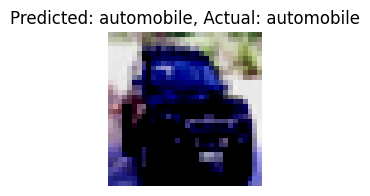

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Load one image
image, label = test_dataset[9] #change the values to test with different images/classes from test dataset.
input_tensor = image.unsqueeze(0).to(device)  # [1, 3, 32, 32]

# Predict
model.eval()
with torch.no_grad():
    output = model(input_tensor)
    predicted = torch.argmax(output, dim=1)

# Get label names
pred_label = class_names[predicted.item()]
true_label = class_names[label]

# Show image and predictions
plt.figure(figsize=(2,2))
plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
plt.title(f'Predicted: {pred_label}, Actual: {true_label}')
plt.axis('off')
plt.show()
